In [9]:
import numpy as np
import pandas as pd
from skew_autotransform import skew_autotransform
import seaborn as sns
from sklearn import linear_model
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

In [17]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
weather_df = pd.read_sql_query('select * from weatherinszeged',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()
weather_df['apparentdifference'] = weather_df['apparenttemperature'] - weather_df['temperature']

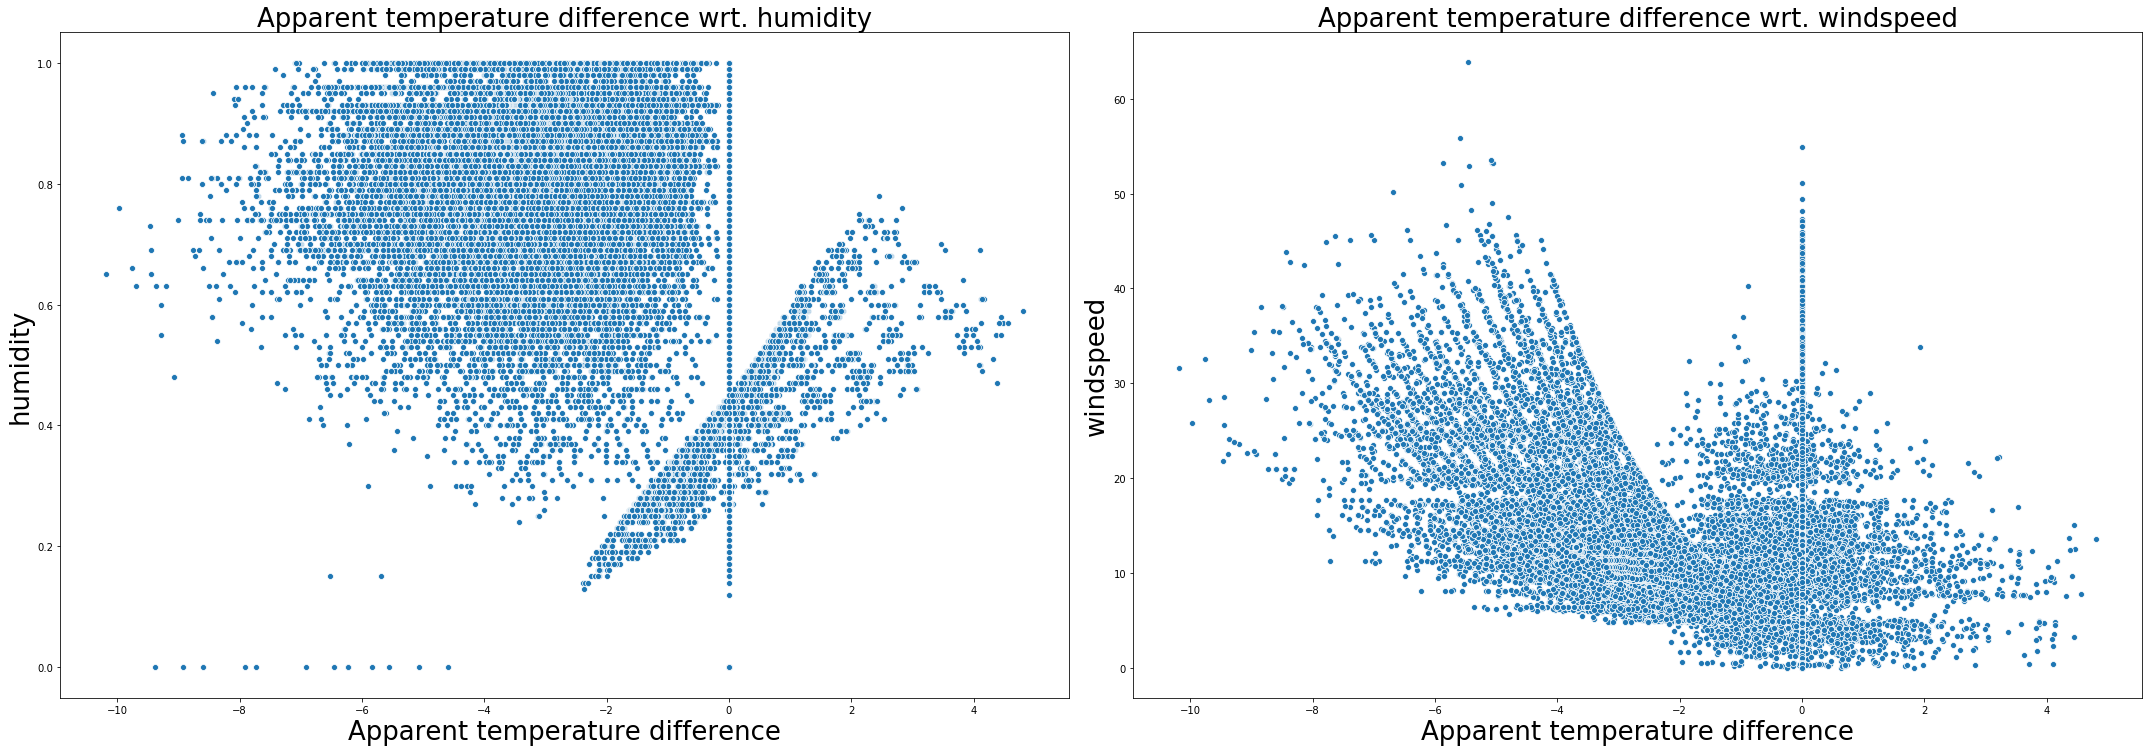

In [19]:
# visualize correlation between explanatory features and target feature
plt.figure(figsize=(30,30))

cols = ['humidity', 'windspeed']
for ind, col in enumerate(cols):
    plt.subplot(3,2,ind+1)
    sns.scatterplot(y=col, x='apparentdifference', data=weather_df)
    plt.title('Apparent temperature difference wrt. {}'.format(col), size=26)
    plt.xlabel('Apparent temperature difference', size=26)
    plt.ylabel(col, size=26)

plt.tight_layout()
plt.show()

# 1. Initial model

In [18]:
target = weather_df['apparentdifference']
data = weather_df[cols]

sm_data = sm.add_constant(data)

results = sm.OLS(target, sm_data).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     apparentdifference   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                 1.949e+04
Date:                Thu, 05 Sep 2019   Prob (F-statistic):               0.00
Time:                        13:33:26   Log-Likelihood:            -1.7046e+05
No. Observations:               96453   AIC:                         3.409e+05
Df Residuals:                   96450   BIC:                         3.409e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4381      0.021    115.948      0.000       2.397       2.479
humidity      -3.0292      0.024   -126.479      0.000      -3.076      -2.982
windspeed     -0.1193      0.001   -176.164      0.000      -0.121      -0.118
==============================================================================
Omnibus:                     3935.747   Durbin-Watson:                   0.267
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4613.311
Skew:                          -0.478   Prob(JB):                         0.00
Kurtosis:                       3.484   Cond. No.                         88.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Assumptions check for initial model:

### 3.1. linearity of the model in its coefficients
- From the plots above, the features aren't linearly correlated and it seems that the data is binomialy distributed with some constant data values that would further lower the model performance. Therefore, it makes sense that this model is performing so poorly.

### 3.2. the error term should be zero on average

In [11]:
lrm = linear_model.LinearRegression()
lrm.fit(data, target)
predictions = lrm.predict(data)
errors = target - predictions
print("Mean of the errors in model is: {:.2}".format(np.mean(errors)))

Mean of the errors in model is: 4.9e-16


The average of the model's error is effectively zero.

### 3.3. homoscedasticity

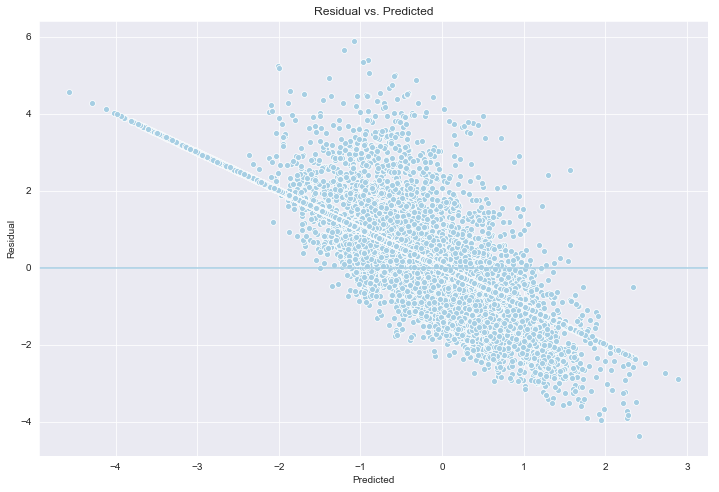

In [14]:
# visualizing homoscedasticity
plt.figure(figsize=(12,8))
sns.scatterplot(x=predictions, y=errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [15]:
# statistical tests for homoscedasticity
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 723.853 and p value is 1.95e-159
Levene test statistic value is 326.038 and p value is 8.95e-73


The p-values of both tests are lower than 0.05. The test results reject the null hypothesis which means our errors are heteroscedastic.

### 3.4. low multicollinearity

In [16]:
corr = weather_df3.corr()
corr.style.background_gradient(cmap='RdBu_r')

,humidity,windspeed,apparentdifference
humidity,1,-0.23084,-0.242212
windspeed,-0.23084,1,-0.41643
apparentdifference,-0.242212,-0.41643,1


Low correlation between explanatory features

### 3.5. error terms should be uncorrelated with one another

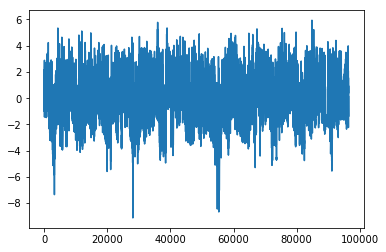

In [12]:
plt.plot(errors)
plt.show()

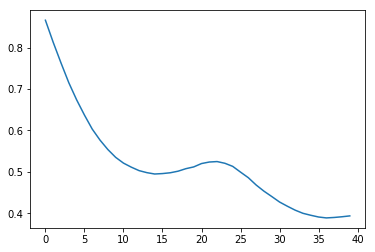

In [13]:
acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

### 3.6. features shouldn't be correlated with the errors

## 4.1. Are the estimated coefficients statistically significant?

both coefficients are statistically significant according to the model's summary.

## 4.2. Are the signs of the estimated coefficients in line with your previous expectations? 
Yes, both humidity and wind speed decrease the apparent temperature difference.

## 4.3. Interpret the estimated coefficients. What are the relations between the target and the explanatory variables?

In [21]:
results.params

const        2.438105
humidity    -3.029186
windspeed   -0.119291
dtype: float64

- A one point increase is wind speed leads to, approximately, 3 degree reduction in difference between apparent temperature and air temperature. In addition, One degree increase in humidity seems to lower the difference between apparent temperature and air temperature by 0.1 dgerees on average. When wind speed and humidity are both zero, apparent temperature is, approximately, 2.5 degreees higher than air tepmerature on average.

## 4.4. Next, include the interaction of humidity and windspeed to the model above and estimate the model using OLS

In [22]:
weather_df['humidity_windspeed'] = weather_df['humidity'] * weather_df['windspeed']

# Model with feature interaction term

In [24]:
target = weather_df['apparentdifference']
data = weather_df[['humidity', 'windspeed', 'humidity_windspeed']]

sm_data = sm.add_constant(data)

results2 = sm.OLS(target, sm_data).fit()

results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     apparentdifference   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.341
Method:                 Least Squares   F-statistic:                 1.666e+04
Date:                Thu, 05 Sep 2019   Prob (F-statistic):               0.00
Time:                        13:41:27   Log-Likelihood:            -1.6669e+05
No. Observations:               96453   AIC:                         3.334e+05
Df Residuals:                   96449   BIC:                         3.334e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0839      0.033      2.511      0.012       0.018       0.149
humidity               0.1775      0.043      4.133      0.000       0.093       0.262
windspeed              0.0905      0.002     36.797      0.000       0.086       0.095
humidity_windspeed    -0.2971      0.003    -88.470      0.000      -0.304      -0.291
==============================================================================
Omnibus:                     4849.937   Durbin-Watson:                   0.265
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9295.404
Skew:                          -0.378   Prob(JB):                         0.00
Kurtosis:                       4.320   Cond. No.                         193.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Are the coefficients statistically significant? Did the signs of the estimated coefficients for humidity and windspeed change?
- All coefficients are still statistically significant. The signs of humidity and wind speed coefficients changed from negative to positive while the new interactions term is negative.

## 4.5. Interpret the estimated coefficients
- The average difference between apparent and air temperature when humidity and wind speed are zero is 0.08 degrees. Given humidity level, a one point increase in windspeed would lead to an average apparent temperature difference of (degrees):  $$apparent difference = 0.09  - 0.3 * humidity$$ 

## 5.1. What are the R-squared and adjusted R-squared values? Do you think they are satisfactory? Why?

In [34]:
print('R\u00b2 value = {:.2f}\nadj. R\u00b2 value = {:.2f}'.format(results.rsquared, results.rsquared_adj))

R² value = 0.29
adj. R² value = 0.29


- Both $R^2$ values are too low. 71% of the variation cannot be explained by the proposed model. Knowing that the explanatory variables aren't linearly correlated with the target variable, from the scatter plots above, a poor model fit is expected.

## 5.2. Next, include the interaction of humidity and windspeed to the model above and estimate the model using OLS. Now, what is the R-squared of this model? Does this model improve upon the previous one?

In [35]:
# results2 is the model with the interaction term from section 4.4. above
print('R\u00b2 value = {:.2f}\nadj. R\u00b2 value = {:.2f}'.format(results2.rsquared, results2.rsquared_adj))

R² value = 0.34
adj. R² value = 0.34


- Including the interaction term improve upon the initial model

## 5.3. Add visibility as an additional explanatory variable to the first model and estimate it

In [38]:
target = weather_df['apparentdifference']
data = weather_df[['humidity', 'windspeed', 'visibility']]

sm_data = sm.add_constant(data)

results3 = sm.OLS(target, sm_data).fit()

results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     apparentdifference   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                 1.401e+04
Date:                Thu, 05 Sep 2019   Prob (F-statistic):               0.00
Time:                        14:55:49   Log-Likelihood:            -1.6938e+05
No. Observations:               96453   AIC:                         3.388e+05
Df Residuals:                   96449   BIC:                         3.388e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5756      0.028     56.605      0.000       1.521       1.630
humidity      -2.6066      0.025   -102.784      0.000      -2.656      -2.557
windspeed     -0.1199      0.001   -179.014      0.000      -0.121      -0.119
visibility     0.0540      0.001     46.614      0.000       0.052       0.056
==============================================================================
Omnibus:                     3833.895   Durbin-Watson:                   0.282
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4584.022
Skew:                          -0.459   Prob(JB):                         0.00
Kurtosis:                       3.545   Cond. No.                         131.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Did R-squared increase? What about adjusted R-squared?

In [41]:
print('R\u00b2 for the model with visibility is {:.2f} larger than the R\u00b2 for the initial model'.format(results3.rsquared - results.rsquared))
print('Adj. R\u00b2 for the model with visibility is {:.2f} larger than the adj. R\u00b2 for the initial model'.format(results3.rsquared_adj - results.rsquared_adj))

R² for the model with visibility is 0.02 larger than the R² for the initial model
Adj. R² for the model with visibility is 0.02 larger than the adj. R² for the initial model


## Compare the differences put on the table by the interaction term and the visibility in terms of the improvement in the adjusted R-squared. Which one is more useful?

In [78]:
print(
    f"{'Initial model':>30}{'+ interaction term':>25}{'+ visibility':>20}",
    f"\n{'R-squared'}{'{:.2f}'.format(results.rsquared):>15}{'{:.2f}'.format(results2.rsquared):>20}{'{:.2f}'.format(results3.rsquared):>25}",
    f"\n{'Adj. R-squared'}{'{:.2f}'.format(results.rsquared_adj):>10}{'{:.2f}'.format(results2.rsquared_adj):>20}{'{:.2f}'.format(results3.rsquared_adj):>25}"

)

                 Initial model       + interaction term        + visibility 
R-squared           0.29                0.34                     0.30 
Adj. R-squared      0.29                0.34                     0.30


- It seems that the interaction term is more informative than visibility

## 5.4. Choose the best one from the three models above with respect to their AIC and BIC scores

In [81]:
print('AIC for interaction model is {:.0f}, compared to {:.0f} for the visibility model'.format(results2.aic, results3.aic))
print('BIC for interaction model is {:.0f}, compared to {:.0f} for the visibility model'.format(results2.bic, results3.bic))

AIC for interaction model is 333393, compared to 338770 for the visibility model
BIC for interaction model is 333431, compared to 338808 for the visibility model


- AIC and BIC for the visibility model is 2% larger than those for the model including the interaction term. This fruther supports choosing the interaction term model as lower AIC and BIC values are more favorable.